In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import pipeline, preprocessing, metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

plt.rcParams['figure.figsize'] = 10, 5

In [ ]:
def rmsle(y_pred, y_true):
    error = np.sqrt(np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean())
    return error

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [55]:
train = pd.read_csv('../data/bike_sharing_train.csv')
test = pd.read_csv('../data/bike_sharing_test.csv')

In [56]:
full_df = pd.concat([train, test])
train_df_idx = train.shape[0]

In [57]:
dt = pd.DatetimeIndex(full_df.datetime)

In [58]:
full_df['hour'] = dt.hour
full_df['day'] = dt.day
full_df['month'] = dt.month
full_df['year'] = dt.year
full_df['dayOfweek'] = dt.dayofweek
full_df['dayOfyear'] = dt.dayofyear
full_df['weekOfyear'] = dt.weekofyear

for c in train.columns[-3:]:
    full_df['{}_log'.format(c)] = np.log(full_df[c]+1)

In [59]:
def select_train_data():
    data = full_df.iloc[:train_df_idx].copy()
    return data

def select_test_data():
    data = full_df.iloc[train_df_idx:].copy()
    return data

In [60]:
train_df = select_train_data()

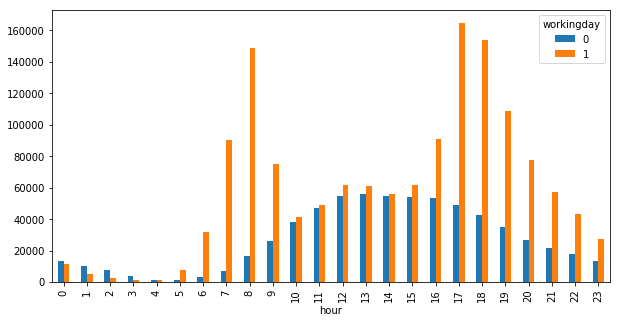

In [62]:
train_df.groupby(['hour', 'workingday'])['count'].agg('sum').unstack().plot(kind='bar');

In [63]:
def vertex(x):
    if (x['workingday'] == 1 and (6 <= x['hour']<=9 or 16<=x['hour']<=23)) \
        or (x['workingday'] == 0 and 10<=x['hour']<=19):
        return 1
    return 0

In [64]:
full_df['vertex'] = full_df[['hour', 'workingday']].apply(vertex, axis=1)

In [65]:
season_count = train_df.groupby('season')[['count']].sum()
season_count.columns =['season_count']
full_df = full_df.join(season_count, ['season'])

In [83]:
def prep_data(data, features):
    X = data[features].as_matrix()
    y_reg = data['registered_log'].as_matrix()
    y_cas = data['casual_log'].as_matrix()
    return X, y_reg, y_cas

In [84]:
def cv_split(data, split=15):
    train = data[data['day'] <= split]
    test = data[data['day'] > split]
    return train, val

In [128]:
def cv_pred(model, features):
    data = select_train_data()
    train, val = cv_split(data)
    X_train, y_train_reg, y_train_cas = prep_data(train, features)
    X_val, y_val_reg, y_val_cas = prep_data(val, features)

    model_reg = model.fit(X_train, y_train_reg)
    y_pred_reg = np.exp(model_reg.predict(X_val)) - 1

    model_cas = model.fit(X_train, y_train_cas)
    y_pred_cas = np.exp(model_cas.predict(X_val)) - 1

    y_pred_total = np.round(y_pred_reg + y_pred_cas)
    y_pred_total[y_pred_total < 0] = 0

    y_val_total = np.exp(y_val_reg) + np.exp(y_val_cas) - 2

    error = rmsle(y_pred_total, y_val_total)
    return (y_pred_total, y_val_total, error)

In [112]:
rf_params = {
             'max_depth': [1, 5, 10, 15, 20],
             'min_samples_split': [2, 5, 7],
             'min_samples_leaf': [1, 2, 3, 5, 7]
            }

boost_params = {
                'n_estimators': [100, 150, 300],
                'max_depth': [1, 3, 5, 7],
                'learning_rate': [0.05, 0.1, 0.5],
                'subsample': [0.5, 0.7, 0.8, 0.9, 0.95, 1]
               }

features = ['atemp', 'holiday', 'humidity', 'season', 'temp', 'weather', 'windspeed',
            'workingday', 'hour', 'day', 'month', 'year', 'dayOfweek', 'dayOfyear',
            'weekOfyear', 'vertex', 'season_count']

In [121]:
current_params = {}
best_params_rf = {}
initial_error = np.inf
best_model = None
for m_d in rf_params['max_depth']:
    for m_s_s in rf_params['min_samples_split']:
        for m_s_l in rf_params['min_samples_leaf']:
            current_params['max_depth']= m_d
            current_params['min_samples_split'] = m_s_s
            current_params['min_samples_leaf'] = m_s_l
            rf = RandomForestRegressor(**current_params,random_state=1)
            _, _, error = cv_pred(rf, features)
            if error < initial_error:
                initial_error = error
                best_model = rf
                best_params['max_depth']= m_d
                best_params['min_samples_split'] = m_s_s
                best_params['min_samples_leaf'] = m_s_l
                print(error)

0.86250513627
0.472697161919
0.472590511748
0.361344739518
0.3607578984
0.355328271387
0.354332233099
0.349092814011
0.343494872491
0.342821583424
0.342070260236
0.342052504064


In [122]:
current_params = {}
best_params_boost = {}
initial_error = np.inf
best_model = None
for n_e in boost_params['n_estimators']:
    for m_d in boost_params['max_depth']:
        for lr in boost_params['learning_rate']:
            for sub in boost_params['subsample']:
                current_params['n_estimators'] = n_e
                current_params['max_depth']= m_d
                current_params['learning_rate'] = lr
                current_params['subsample'] = sub
                boost = XGBRegressor(**current_params, seed=1)
                _, _, error = cv_pred(boost, features)
                if error < initial_error:
                    initial_error = error
                    best_model = boost
                    best_params['n_estimators'] = n_e
                    best_params['max_depth']= m_d
                    best_params['learning_rate'] = lr
                    best_params['subsample'] = sub
                    print(error)

0.698394665286
0.593364305101
0.516663261083
0.511983840543
0.510378406161
0.409264571847
0.345404295029
0.344844814176
0.332587370644
0.325370033276
0.311361675754
0.30955965757
0.307928364599
0.305514437789


In [123]:
def final_pred(model, features):

    df_train = select_train_data()
    df_test = select_test_data()
    
    X_train = df_train[features].as_matrix()
    y_train_cas = df_train['casual_log'].as_matrix()
    y_train_reg = df_train['registered_log'].as_matrix()

    X_test = df_test[features].as_matrix()
    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas) - 1
    
    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg) - 1
    
    y_pred_total = y_pred_cas + y_pred_reg
    
    return y_pred_total

In [124]:
rf = RandomForestRegressor(**best_params_rf)
xgb = XGBRegressor(**best_params_boost)

In [130]:
rf_pred, y_val, _ = cv_pred(rf, features)
xgb_pred, y_val, _ = cv_pred(xgb, features)

In [142]:
errors = []
for alpha in np.linspace(0.1, 0.9, 9):
    y_pred = rf_pred*alpha + xgb_pred*(1-alpha)
    error = rmsle(y_pred, y_val)
    errors.append((error, alpha))
errs_srtd = sorted(errors, key=lambda x:x[0], reverse=False)
errs_srtd

[(0.3283521159877581, 0.5),
 (0.32892237551712367, 0.59999999999999998),
 (0.32942530486323296, 0.40000000000000002),
 (0.33115111905012945, 0.70000000000000007),
 (0.33214187038447174, 0.30000000000000004),
 (0.33507108768199473, 0.80000000000000004),
 (0.33651694119297987, 0.20000000000000001),
 (0.34073944684782331, 0.90000000000000002),
 (0.34258391570184477, 0.10000000000000001)]

In [143]:
alpha = errs_srtd[0][1]
rf_pred = final_pred(rf, features)
xgb_pred = final_pred(xgb, features)
y_pred = rf_pred*alpha + xgb_pred*(1-alpha)

In [145]:
df_test = select_test_data()
df_test['count'] = y_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('submit_24.csv', index=False)